In [1]:
from virgo.data.cluster import VirgoCluster
from virgo.data.cleaner import AutoDensityCleaner
from virgo.models.kernel import VirgoKernel
from virgo.models.mixture import VirgoMixture

%load_ext autoreload
%autoreload 2

# %matplotlib notebook
%matplotlib inline

Reading  4537474  particles
Data set 0 - Shape: (491318, 9)
Mean / Std: 279602.354 / 827754.060
Min / Max: -1.000 / 4537471.000
Data set 1 - Shape: (491318, 8)
Mean / Std: 0.000 / 1.000
Min / Max: -1.903 / 5.705


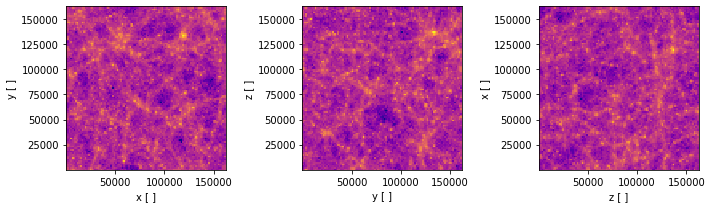

In [2]:
filebase = f"/home/max/Software/virgo/data/box_mhd/MHD_box_snap_019"

virgo_cluster = VirgoCluster(
    file_name=filebase, io_mode=1, cut_mach_dim=-2, n_max_data=1000000, 
)
# virgo_cluster.data = virgo_cluster.data[:, :-1]

virgo_cluster.scale_data()
virgo_cluster.print_datastats()
virgo_cluster.plot_raw_hists(
    bins=100, plot_range=None,
)

In [ ]:
virgo_kernel = VirgoKernel(virgo_cluster, k_nystroem=120, pca_comp=5)
virgo_kernel()
virgo_cluster.print_datastats()

In [ ]:
virgo_mixture = VirgoMixture(virgo_cluster, n_comp=35)
elbo = virgo_mixture.fit()

print(f"ELBO: {elbo}")
print(f"Mixture weights {virgo_mixture.model.weights_}")

virgo_mixture.predict(remove_uncertain_labels=False)
labels_removed = virgo_cluster.get_labels(return_counts=True)
print(labels_removed)

# virgo_cluster.plot_cluster(cmap_vmax=4, n_step=25, plot_kernel_space=True, store_gif=False, gif_title="nystroem_separation_kernelspace")
virgo_cluster.plot_cluster(n_step=25, store_gif=False, gif_title="nystroem_separation_kernelspace")

In [ ]:
auto_cleaner = AutoDensityCleaner(virgo_cluster, pick_top=10)
auto_cleaner.clean()
print(virgo_cluster.get_labels(return_counts=True))
virgo_cluster.plot_cluster(n_step=5, store_gif=False, gif_title=f"box_gmm35_big10")

In [ ]:
# n_max=1000000, gmm=35, top 10
# k_nystroem=2000, comp=5, k_nystroem=1000
# 0 group  [0.162, 100]
# 1 single [0.16, 100]
# 2 single [0.2, 100]
# 3 two    [0.25, 100]
# 4 two    [0.3, 100]
# 5 single [0.2, 100]
# 6 two    [0.2, 100]
# 7 barely [0.18, 50]
# 8 barely [0.2, 50]
# 9 barely [0.25, 100]
for i in virgo_cluster.get_labels():
    if i in [-1, ]:
        continue

    vc_2 = VirgoCluster(file_name=None)
    vc_2.data = virgo_cluster.cluster[virgo_cluster.cluster_labels == i]
    vc_2.scale_data()
    
    virgo_kernel_2 = VirgoKernel(vc_2, k_nystroem=2000, pca_comp=5)
    virgo_kernel_2()
    vc_2.print_datastats()
    
    virgo_mixture_2 = VirgoMixture(vc_2, n_comp=10)
    elbo = virgo_mixture_2.fit()
    virgo_mixture_2.predict(remove_uncertain_labels=False)
    labels_removed = vc_2.get_labels(return_counts=True)
    print(labels_removed)
    vc_2.plot_cluster(n_step=5)
    
    auto_cleaner = AutoDensityCleaner(vc_2)
    auto_cleaner.clean()
    print(vc_2.get_labels(return_counts=True))
    vc_2.plot_cluster(n_step=5)
    
    vc_3 = VirgoCluster(file_name=None)
    vc_3.data = vc_2.cluster[vc_2.cluster_labels >=0]
    vc_3.scale_data()
    
    virgo_kernel_3 = VirgoKernel(
        vc_3, k_nystroem=1000, pca_comp=6, spatial_dim=[0, 1, 2, 3, 4, 5]
    )
    virgo_kernel_3(virgo_kernel_3.custom_kernel)
    
#     ll_est = pred_ll(vc_2.scaled_data, i)
#     ll_est = get_avg_nn_dist(vc_2.scaled_data, ind=i)
#     print("LL ", i, ll_est, vc_2.scaled_data.std(), vc_2.scaled_data.var())
    vc_3.run_fof(
#         linking_length=ll_est,
        min_group_size=100,
        use_scaled_data=True,
    )

    labels, counts = vc_3.get_labels(return_counts=True)
    print(labels, counts)
#     vc_3.plot_cluster(n_step=1, plot_kernel_space=True)
    vc_3.plot_cluster(n_step=1, maker_size=3.0)
#     vc_3.plot_cluster(n_step=1, maker_size=3.0, store_gif=True, gif_title=f"box_{i}")

#     break
    labels, counts = vc_3.get_labels(return_counts=True)
    vc_3.cluster_labels[vc_3.cluster_labels < 0] = labels.shape[0] -1 
    vc_3.plot_cluster(n_step=1)
    vc_3.export_cluster(f"vc_box_fitted_set{i}", remove_uncertain=False, remove_evno=True)
    break